In [7]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Shubh/OneDrive/Desktop/eCommerceData'


def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'


for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)

    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)

cur = db.cursor()



# List all unique cities where customers are located.

In [80]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["City"])
df.head(10)


,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# Count the number of orders placed in 2017.

In [17]:
query = """ select count(order_id) as Order_Count FROM orders where year(order_purchase_timestamp) = 2017; """
cur.execute(query)
data = cur.fetchall()
"Total Order that placed in 2017:", data[0][0]

('Total Order that placed in 2017:', 90202)

# Find the total sales per category.

In [26]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2) sales from products join 
            order_items on products.product_id = order_items.product_id join 
            payments on payments.order_id = order_items.order_id group by category; """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Catagory", "Sales"])
df



,Catagory,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [30]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end )) / count(*)*100 from payments """
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments are: ",data[0][0]

('the percentage of orders that were paid in installments are: ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

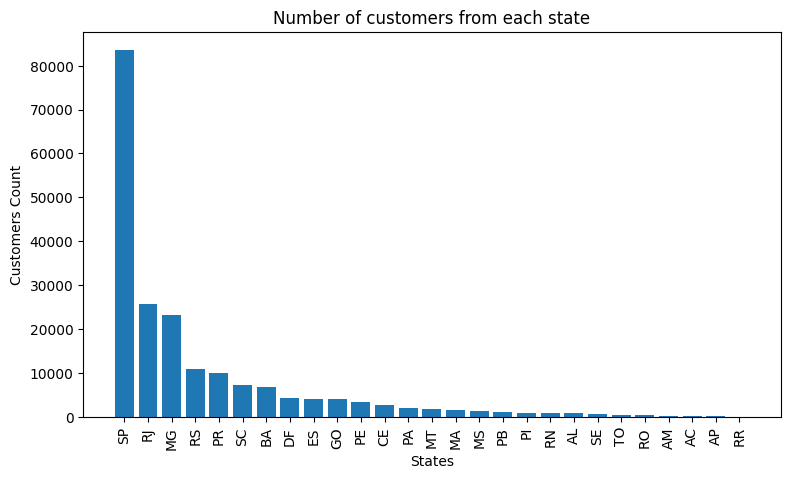

In [51]:
query = """ SELECT customer_state, count(customer_id) FROM customers group by customer_state; """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["state", "customers"])
df = df.sort_values(by = "customers", ascending= False)

plt.figure(figsize = (9, 5))
plt.bar(df["state"], df["customers"])
plt.xlabel("States")
plt.ylabel("Customers Count")
plt.title("Number of customers from each state")
plt.xticks(rotation = 90)

plt.show()

# Calculate the number of orders per month in 2018.

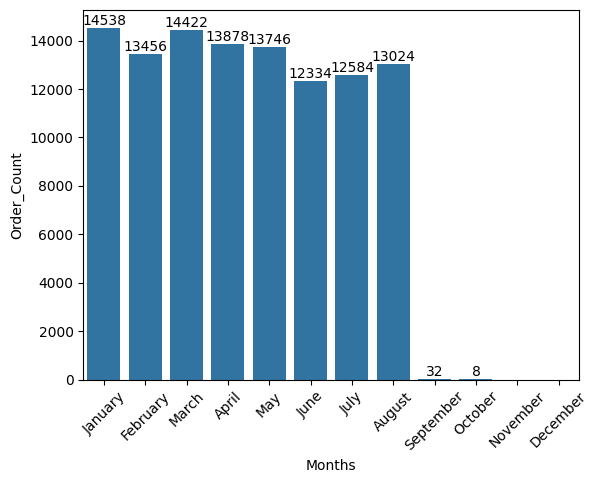

In [49]:
query = """ select monthname(order_purchase_timestamp) month, count(order_id) order_count from orders where year(order_purchase_timestamp) = 2018 group by month """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Months","Order_Count"])
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
ax = sns.barplot(x = df["Months"], y = df["Order_Count"], data = df, order = o)
plt.title("Number of orders per month in 2018")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0]) 
plt.show()

# Find the average number of products per order, grouped by customer city.

In [55]:
query = """ with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc from orders 
join order_items on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) avg_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by avg_orders desc
;
 """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Customer City", "Average Orders/Order"])
df.head(10)


,Customer City,Average Orders/Order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


# Calculate the percentage of total revenue contributed by each product category.

In [57]:
query = """ select upper(products.product_category) category, round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage from products join 
order_items on products.product_id = order_items.product_id join 
payments on payments.order_id = order_items.order_id group by category order by sales_percentage desc; """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Catagory", "Sales_percentage"])
df.head(10)




,Catagory,Sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times a product has been purchased.

In [71]:
query = """ select products.product_category, count(order_items.product_id), round(avg(order_items.price),2) from products join order_items 
on products.product_id  = order_items.product_id 
group by products.product_category ; """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Catagory", "Order_Count", "Avrage_Price"])

arr1 = df["Order_Count"]
arr2 = df["Avrage_Price"]

a = np.corrcoef([arr1, arr2])
print("The correlation between product price and the number of times a product has been purchased is:", a[0][-1])

The correlation between product price and the number of times a product has been purchased is: -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

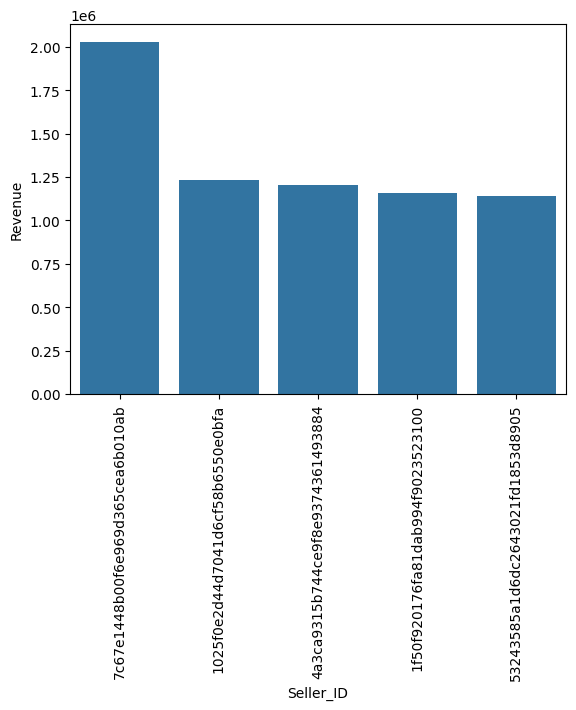

In [83]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from (select order_items.seller_id, round(sum(payments.payment_value),2) revenue from order_items join payments 
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a ; """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Seller_ID", "Revenue", "Rank"])
df = df.head(5)
sns.barplot(x = "Seller_ID", y = "Revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [88]:
query = """ select customer_id, order_purchase_timestamp, payment, avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from 
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment from payments
join orders on payments.order_id = orders.order_id) as a;
 """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Cutomer_ID", "Order_purchase_date", "Payment", "Moving_Average"])
df

,Cutomer_ID,Order_purchase_date,Payment,Moving_Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
623311,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623312,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623313,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
623314,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [89]:
query = """ select years, months, payment, sum(payment) over (order by years, months) cumulative_sales from (select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments on 
orders.order_id = payments.order_id
group by years, months order by years, months) as a;

 """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["years", "months", "payment", "cumulative_sales"])
df

,years,months,payment,cumulative_sales
0,2016,9,1513.44,1513.44
1,2016,10,354542.88,356056.32
2,2016,12,117.72,356174.04
3,2017,1,830928.24,1187102.28
4,2017,2,1751448.06,2938550.34
5,2017,3,2699181.60,5637731.94
6,2017,4,2506728.18,8144460.12
7,2017,5,3557512.92,11701973.04
8,2017,6,3067658.28,14769631.32
9,2017,7,3554297.52,18323928.84


# Calculate the year-over-year growth rate of total sales.

In [92]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments on 
orders.order_id = payments.order_id
group by years order by years)
select years, (payment - lag(payment, 1) over(order by years)) / (lag(payment, 1) over(order by years)) * 100 as previous_year from a
;
 """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["years","Year of Year Growth(%)"])
df

,years,Year of Year Growth(%)
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [101]:
query = """ with a as(select customers.customer_id, min(orders.order_purchase_timestamp) first_order from customers
join orders on customers.customer_id = orders.customer_id
group by customers.customer_id),
b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order 
from a join orders on orders.customer_id = a.customer_id and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count(distinct a.customer_id) / count(distinct b.customer_id))
from a left join b on a.customer_id = b.customer_id;
 """
cur.execute(query)
data = cur.fetchall()
data
print("There is no customer avail who make purchase within 6 months of their first purchase.")
# if data == "":
#     print("There is no customer avail who make purchase within 6 months of their first purchase.")
# else:
#     data

# df = pd.DataFrame(data)
# df

There is no customer avail who make purchase within 6 months of their first purchase.


# Identify the top 3 customers who spent the most money in each year.

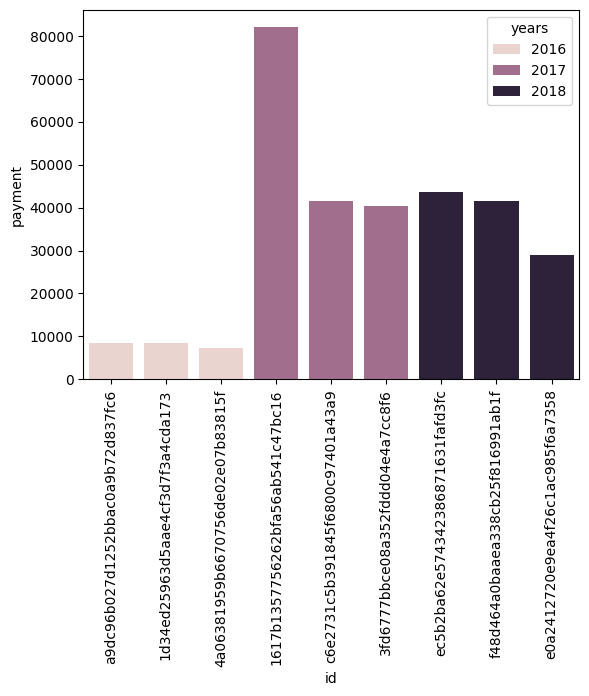

In [102]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()